In [44]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


from sklearn.utils import check_random_state
# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
from abc import ABCMeta

# import open bandit pipeline (obp)
from obp.dataset import SyntheticBanditDataset, OpenBanditDataset
from obp.dataset import linear_reward_function, logistic_reward_function
from obp.dataset import SyntheticBanditDatasetWithActionEmbeds
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
    SelfNormalizedDoublyRobust as SNDR
)

from main import (
    NeighborhoodModel,
    eval_policy,
    # create_simluation_data_from_pi,
    # sample_policy_actions
)
random_state=12345

In [45]:
n_val_data= 4000
n_test_data = 5

n_actions= 100
n_users = 100
beta = -1
n_def_actions= 0.0
reward_std = 2.5
random_state= 12345

num_runs = 5 # number of simulations
max_iter = 25 # number of epochs
emb_dim = 5

random_ = check_random_state(random_state)
num_rounds_list = [3, 6, 10, 15, 20]
sigma = 0.1

In [46]:
# general user tendencies
eps = 0.5
emb_a = random_.normal(size=(n_actions, emb_dim))
noise_a = random_.normal(size=(emb_dim))
our_a = (1-eps) * emb_a + eps * noise_a

original_a = our_a.copy()

emb_x = random_.normal(size=(n_users, emb_dim))
noise_x = random_.normal(size=(emb_dim)) 
our_x = (1-eps) * emb_x + eps * noise_x

original_x = our_x.copy()

# M_h = random_.normal(size=(emb_dim, emb_dim))
# b_h = random_.normal(size=(1, n_actions))

# score = emb_x @ emb_a.T
# score = emb_x @ M_h @ emb_a.T

score = emb_x @ emb_a.T
score = random_.normal(score, scale=sigma)
q_x_a = 1 / (3.0 + np.exp(-score))

In [47]:
q_x_a.mean()

0.22126072713801018

In [48]:
def create_simluation_data_from_pi(pi: np.ndarray, q_x_a: np.ndarray, n_users: np.int, n_actions: np.int, random_state: int = 12345):
    random_ = check_random_state(random_state)
    simulation_data = {'actions':np.zeros((n_actions, n_users), dtype=np.int32), 
                       'users': np.zeros((n_actions, n_users), dtype=np.int32), 
                       'reward':np.zeros((n_actions, n_users)),
                       'pscore':np.zeros((n_actions, n_users))}
    simulation_data['pi_0'] = pi
    actions = []
    for i in range(n_users):
        user_actions = random_.choice(np.arange(n_actions), size=n_actions, p=pi[i], replace=False)
        actions.append(np.array(user_actions))

    actions = np.vstack(actions)
    for i in range(n_actions):
        simulation_data['actions'][i] = actions[:, i]
        simulation_data['users'][i] = np.arange(n_users)
        simulation_data['reward'][i] = np.squeeze(q_x_a[np.arange(n_users), simulation_data['actions'][i]])
        simulation_data['pscore'][i] = np.squeeze(pi[np.arange(n_users), simulation_data['actions'][i]])

    return simulation_data

In [49]:
simulation_data = create_simluation_data_from_pi(np.ones_like(q_x_a)/(n_actions), q_x_a, n_users, n_actions)

In [50]:
class CFModel(nn.Module):
    def __init__(self, num_users, num_actions, embedding_dim, 
                 initial_user_embeddings=None, initial_actions_embeddings=None):

        super(CFModel, self).__init__()
        self.num_actions = num_actions
        self.num_users = num_users

        
        # Initialize user and actions embeddings
        if initial_user_embeddings is None:
            self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        else:
            # If initial embeddings are provided, set them as the embeddings
            self.user_embeddings = nn.Embedding.from_pretrained(initial_user_embeddings, freeze=False)
        
        if initial_actions_embeddings is None:
            self.actions_embeddings = nn.Embedding(num_actions, embedding_dim)
        else:
            # If initial embeddings are provided, set them as the embeddings
            self.actions_embeddings = nn.Embedding.from_pretrained(initial_actions_embeddings, freeze=False)

    def get_params(self):
        return self.actions_embeddings(torch.arange(self.num_actions)), self.user_embeddings(torch.arange(self.num_users))
        
    def forward(self, user_ids):
        # Get embeddings for users and actions
        user_embedding = self.user_embeddings(user_ids)
        actions_embedding = self.actions_embeddings
        
        # Calculate dot product between user and actions embeddings
        scores = user_embedding @ actions_embedding(torch.arange(self.num_actions)).T
        
        # Apply softmax to get the predicted probability distribution
        return F.softmax(scores, dim=1).unsqueeze(-1)

In [51]:
class CustomCFDataset(Dataset):
    def __init__(self, user_idx, action_idx, rewards, original_prob):
        """
        Args:
            np_arrays (list of np.ndarray): List of numpy arrays
        """
        self.user_idx = user_idx
        self.action_idx = action_idx
        self.rewards = rewards
        self.original_prob = original_prob

    def __len__(self):
        return len(self.rewards)

    def __getitem__(self, idx):   
        # Convert list to tensor
        user = torch.tensor(self.user_idx[idx].squeeze())
        action =  torch.tensor(self.action_idx[idx].squeeze())
        reward = torch.tensor(self.rewards[idx].squeeze(), dtype=torch.double)
        action_dist = torch.tensor(self.original_prob[user].squeeze())
        
        return user, action, reward, action_dist

In [52]:
class PolicyLoss(nn.Module):
    def __init__(self):
        super(PolicyLoss, self).__init__()

    def forward(self, pscore, scores, policy_prob, original_policy_rewards, original_policy_actions):

        n = original_policy_actions.shape[0]
        iw = policy_prob[torch.arange(n), original_policy_actions] / pscore
        
        q_hat_at_position = scores[torch.arange(n), :]
        q_hat_factual = scores[torch.arange(n), original_policy_actions]

        pi_e_at_position = policy_prob[torch.arange(n), :]
        estimated_rewards = ((q_hat_at_position * pi_e_at_position).sum(axis=1) / (pi_e_at_position.sum(axis=1))).squeeze()
        estimated_rewards = estimated_rewards + (iw @ (original_policy_rewards - q_hat_factual)) / iw.sum()
        # return estimated_rewards
        # value = self.ope_fn.estimate_policy_value(original_policy_rewards, original_policy_actions, original_policy_prob, scores, pscore=pscore)
        return 1 - estimated_rewards.mean()

In [53]:
result_path = Path(f"./result/{datetime.now().strftime('%Y-%m-%d')}/train_data")
result_path.mkdir(parents=True, exist_ok=True)
result_file_name = f"result_{datetime.now().strftime('%H:00')}.csv"
curve_file_name = f"curve_{datetime.now().strftime('%H:00')}.csv"
print(result_file_name)

result_12:00.csv


In [54]:
test_data = dict(
        num_data=n_test_data*n_users,
        num_actions=n_actions,
        x=our_x[simulation_data['users'][:n_test_data].flatten()],
        a=simulation_data['actions'][:n_test_data].flatten(),
        r=simulation_data['reward'][:n_test_data].flatten(),
        x_idx=simulation_data['users'][:n_test_data].flatten(),
        pi_0=simulation_data['pi_0'],
        pscore=simulation_data['pscore'][:n_test_data].flatten(),
        q_x_a=q_x_a,
    )

In [55]:
# 4. Define the training function
def train(model, train_loader, criterion, optimizer, neighborhood_model, num_epochs=2):
    
    tq = tqdm(range(num_epochs))
    for epoch in tq:
        model.train()  # Set the model to training mode
        running_loss = 0.0
        # correct_predictions = 0
        total_samples = 0
        
        for user_idx, action_idx, rewards, original_prob in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                user_idx, action_idx, rewards, original_prob = user_idx.cuda(), action_idx.cuda(), rewards.cuda(), original_prob.cuda()
                model.cuda()
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            policy = model(user_idx)
            pscore = original_prob[torch.arange(user_idx.shape[0]), action_idx.type(torch.long)]
            
            scores = torch.tensor(neighborhood_model.predict(user_idx))
            
            loss = criterion(pscore, scores, policy, rewards, action_idx.type(torch.long))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            action_emb, context_emb = model.get_params()
            neighborhood_model.update(action_emb.detach().numpy(), context_emb.detach().numpy())
            
            # Calculate running loss and accuracy
            running_loss += loss.item()
            # _, predicted = torch.max(outputs, 1)
            total_samples += 1
            # correct_predictions += (predicted == labels).sum().item()
        
            # Print statistics after each epoch
            epoch_loss = running_loss / total_samples
            tq.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [ ]:
# original_policy_prob = np.expand_dims(softmax(original_x @ original_a.T, axis=1), -1)
original_policy_prob = np.expand_dims(np.ones_like(q_x_a) / (n_actions), -1)
dm = DM()
results = {}
num_runs = 1
batch_size = 50
num_neighbors = 4
first = True

for train_size in num_rounds_list:
    reg_results, conv_results = [], []
    for run in range(num_runs):
        idx = np.arange(train_size) + n_test_data
        # idx = random_.choice(idx, size=train_size, replace=False)
        train_data = dict(num_data=train_size,
                                    num_actions=n_actions,
                                    x=our_x[simulation_data['users'][idx].flatten()],
                                    a=simulation_data['actions'][idx].flatten(),
                                    r=simulation_data['reward'][idx].flatten(),
                                    x_idx=simulation_data['users'][idx].flatten(),
                                    pi_0=simulation_data['pi_0'],
                                    pscore=simulation_data['pscore'][idx].flatten(),
                                    q_x_a=q_x_a
                                    )
        regression_model = RegressionModel(
                                            n_actions=n_actions,
                                            action_context=emb_x,
                                            base_model=LogisticRegression(random_state=12345)
                                            )
        regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())

        neighberhoodmodel = NeighborhoodModel(
                                                train_data['x_idx'],
                                                train_data['a'], 
                                                our_a,
                                                our_x, 
                                                train_data['r'], 
                                                num_neighbors=num_neighbors
                                            )
        
        model = CFModel(n_users, n_actions, emb_dim, initial_user_embeddings=torch.tensor(our_x), initial_actions_embeddings=torch.tensor(our_a))
        dataset =  CustomCFDataset(train_data['x_idx'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx']])
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        adam = optim.Adam(model.parameters())
        loss_fn = PolicyLoss()
        
        train(model, train_loader, loss_fn, adam, neighberhoodmodel)

        our_a, our_x = model.get_params()
        our_a, our_x = our_a.detach().numpy(), our_x.detach().numpy()

        print(np.mean(np.abs(emb_a-our_a)))
        print(np.mean(np.abs(original_a-our_a)))

        policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)
        reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))

        conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
        reg_results.append(reg_dm)

        print(conv_results[-1])
        print(reg_dm)
        
        conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_a-our_a)), np.mean(np.abs(original_a-our_a))])
        our_a, our_x = original_a.copy(), original_x.copy()

    # reg_results = np.array(reg_results)
    conv_results = np.array(conv_results)

    results[train_size] = dict(
                                # reg_rewards=np.mean(reg_results[: ,0]),
                                reg_dm=np.mean(reg_results[: ,0]), 
                                # reg_dr=np.mean(reg_results[: ,2]),
                                # reg_ipw=np.mean(reg_results[: ,3]),
                                # reg_sndr=np.mean(reg_results[: ,4]),
                                # reg_var_dm=np.std(reg_results[: ,1] - reg_results[: ,0]),
                                # reg_var_dr=np.std(reg_results[: ,2] - reg_results[: ,0]),
                                # reg_var_ipw=np.std(reg_results[: ,3] - reg_results[: ,0]),
                                # reg_var_sndr=np.std(reg_results[: ,4] - reg_results[: ,0]),
                                
                                policy_rewards=np.mean(conv_results[: ,0]),
                                conv_dm=np.mean(conv_results[: ,1]), 
                                conv_dr=np.mean(conv_results[: ,2]),
                                conv_ipw=np.mean(conv_results[: ,3]),
                                conv_sndr=np.mean(conv_results[: ,4]),
                                diff_to_real=np.mean(conv_results[: ,5]),
                                diff_from_start=np.mean(conv_results[: ,6])
                                # conv_var_dm=np.std(conv_results[: ,1] - conv_results[: ,0]),
                                # conv_var_dr=np.std(conv_results[: ,2] - conv_results[: ,0]),
                                # conv_var_ipw=np.std(conv_results[: ,3] - conv_results[: ,0]),
                                # conv_var_sndr=np.std(conv_results[: ,4] - conv_results[: ,0]),
                            )

ValueError: `pscore` must be 1D array, but got 2D array

In [40]:
df = pd.DataFrame.from_dict(results, orient='index')

In [41]:
df

,policy_rewards,conv_dm,conv_dr,conv_ipw,conv_sndr,diff_to_real,diff_from_start
3,0.318058,0.251502,0.260485,0.250053,0.260773,0.526503,0.009229
6,0.318065,0.252487,0.261313,0.250267,0.261620,0.520940,0.018319
10,0.317714,0.254812,0.263420,0.250868,0.263740,0.514480,0.030514
15,0.317732,0.255969,0.266241,0.251457,0.266654,0.507115,0.046337
20,0.318089,0.258441,0.267007,0.252337,0.267378,0.498640,0.060605


In [42]:
df['getting closer to real to real'] = df['diff_to_real'].max() - df['diff_to_real']

<Axes: >

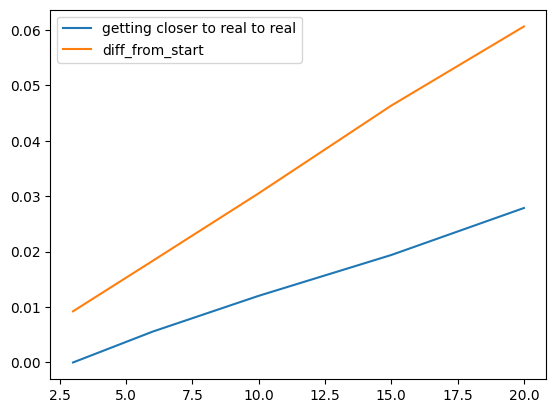

In [43]:
df.plot(y=['getting closer to real to real', 'diff_from_start'])